[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/me-manu/gammaALPs/blob/master/docs/tutorials/mixing_gmf.ipynb)

# Mixing in the magnetic field of the Milky Way

This tutorial demonstrates mixing in the Galactic mangetic field (GMF) of the Milky Way.
The GMF will be modeled here through the model of the coherent component put forward by <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...757...14J/abstract">Jansson & Farrar (2012)</a>.

In addition to the simple photon-ALP oscillation calculation as a function of energy also shown in the other tutorials, here we also demonstrate how one can extract the mixing as a function of propagation distance, which nicely demonstrates the effect of the different B-field components of the <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...757...14J/abstract">Jansson & Farrar model</a>.

In the second part of the tutorial, we show one can generate an all-sky map for the photon-ALP conversion probability in the GMF using `healpy`. If you want to run the tutorial notebook yourself, make sure that you have `healpy` installed; it's not a requirement to run gammaALPs. For installing `healpy` check out the documentation <a href="https://healpy.readthedocs.io/en/latest/">here</a>.

If you haven't installed `gammaALPs` already, you can do so using `pip`. Just uncomment the line below:

In [1]:
#!pip install gammaALPs

We begin with the usual imports:

In [3]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, PathPatch
from matplotlib.text import TextPath
from matplotlib.transforms import Affine2D


effect  = dict(path_effects=[withStroke(foreground="w", linewidth=2)])  # used for plotting

Next we initialize the module. We assume a pure ALP beam as the initial state that enters the Milky Way.

In [5]:
EGeV = np.logspace(-1., 3., 101)  # the energy range, roughly mathing the Fermi-LAT energy range
src = Source(z=0.017559, l=20., b=20.)  # some dummy source for initialization
pa_in = np.diag([0., 0., 1.])  # the inital polarization matrix; a pure ALP state

ml = ModuleList(ALP(m=1., g=1.), src, pin=pa_in, EGeV=EGeV, seed=0)

# add the GMF propagation module
ml.add_propagation("GMF", 0, model='jansson12')

environs.py:1196 --- INFO: Using inputted chi


### A comment on the geometry adopted in gammaALPs

To calculate the Galactic magnetic field parallel to the two photon polarization states, a local coordinate system along the line of sight is defined and the B field is projected onto the transversal axis, which are called $\hat{l}$ and $\hat{b}$, see the 3D plot below.

In case a source is added (which is not the case in this tutorial), the $\psi$ angle, i.e., the angle between the $\hat{y}$ axis in the source frame and the $B$ field is related to the local coordinate system through
$$ \tan\psi = \frac{\langle \vec{B}, -\hat{b}\rangle}{\langle \vec{B}, \hat{l}\rangle}.$$

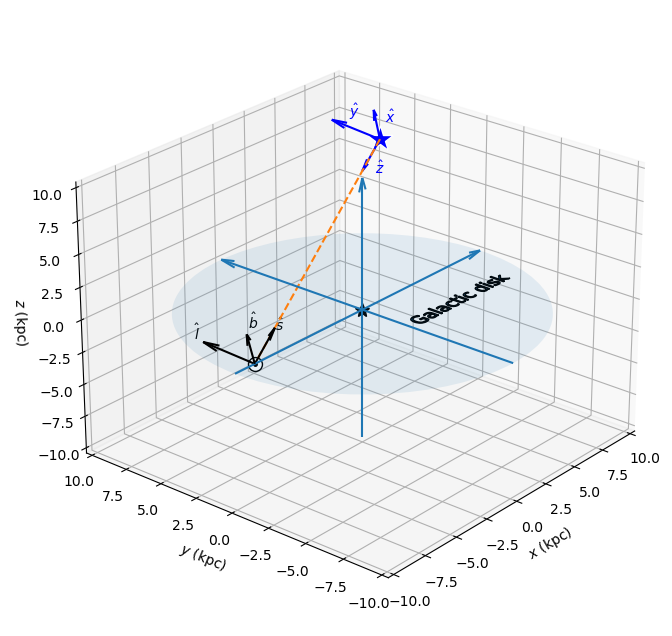

In [6]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


# Earth and GC position
ax.plot(-8.5, 0., ms=10, mec='k', mfc='w', marker='o')
ax.plot(-8.5, 0., ms=5, color='k', marker='.')
ax.plot(0., 0., ms=10, color='k', marker='*')

# Axes
start = -10.
length = 20.
axes = [[start, 0., 0., length, 0., 0.],
        [0., start, 0., 0., length, 0.],
        [0., 0., start, 0., 0., length]]
X, Y, Z, U, V, W = zip(*axes)

ax.quiver(X, Y, Z, U, V, W, arrow_length_ratio=.05, normalize=False)

# arrows to source
x_earth, y_earth, z_earth = np.array([-8.5]), np.array([0.]), np.array([0.])

def uvw_gal(l, b, shift_b=0., shift_l=0.):
    if np.isscalar(l):
        l = np.array([l])
    if np.isscalar(b):
        b = np.array([b])

    u = np.cos(np.deg2rad(b) + shift_b) * np.cos(np.deg2rad(l) + shift_l)
    v = np.cos(np.deg2rad(b) + shift_b) * np.sin(np.deg2rad(l) + shift_l)
    w = np.sin(np.deg2rad(src.b) + shift_b)

    return u,v,w


source_distance = 20.
u, v, w = uvw_gal(src.l, src.b)

# arrow to source
ax.quiver(x_earth, y_earth, z_earth,
          u, v, w,
          arrow_length_ratio=.001, normalize=False, length=source_distance, color="C1", ls='--')

# local coordinate system at Earth
ax.quiver(x_earth, y_earth, z_earth,
          u, v, w,
          arrow_length_ratio=.3, normalize=True, length=3., color="k", ls='-')
ax.text((x_earth + u)[0] + 0.5, (y_earth + v)[0]-0.5, (z_earth + w)[0] + 1.5,
        "$\hat{s}$", color='k')


u, v, w = uvw_gal(src.l + 90., src.b)
ax.quiver(x_earth, y_earth, z_earth,
          u, v, w,
          arrow_length_ratio=.3, normalize=True, length=3., color="k", ls='-')
ax.text((x_earth + u)[0], (y_earth + v)[0] + 3., (z_earth + w)[0],
        "$\hat{l}$", color='k')

u, v, w = uvw_gal(src.l, src.b, shift_b=np.pi / 2.)
ax.quiver(x_earth, y_earth, z_earth,
          u, v, w,
          arrow_length_ratio=.3, normalize=True, length=3., color="k", ls='-')
ax.text((x_earth + u)[0] - 0.3, (y_earth + v)[0], (z_earth + w)[0] + 2.,
        "$\hat{b}$", color='k')


# coordinate system at source
u, v, w = uvw_gal(src.l, src.b)
x_src = x_earth + source_distance * u
y_src = y_earth + source_distance * v
z_src = z_earth + source_distance * w

plt.plot(x_src, y_src, z_src, marker="*", mec="w", mfc="b", ms=20.)

u, v, w = uvw_gal(src.l, src.b, shift_b=np.pi)
ax.quiver(x_src, y_src, z_src,
          u, v, w,
          arrow_length_ratio=.3, normalize=True, length=3., color="b", ls='-')
ax.text((x_src + u)[0] - 0.5, (y_src + v)[0] - 0.5, (z_src + w)[0] - 1.5, "$\hat{z}$", color='b')

u, v, w = uvw_gal(src.l + 90., src.b)
ax.quiver(x_src, y_src, z_src,
          u, v, w,
          arrow_length_ratio=.3, normalize=True, length=3., color="b", ls='-')
ax.text((x_src + u)[0] + 0.5, (y_src + v)[0] + 1.5, (z_src + w)[0] + 0.5, "$\hat{y}$", color='b')

u, v, w = uvw_gal(src.l, src.b, shift_b=np.pi / 2.)
ax.quiver(x_src, y_src, z_src,
          u, v, w,
          arrow_length_ratio=.3, normalize=True, length=3., color="b", ls='-')
ax.text((x_src + u)[0], (y_src + v)[0] - 0.5, (z_src + w)[0] + 0.7, "$\hat{x}$", color='b')

# Galactic disk
p = Circle((0, 0), 10, alpha=0.1, zorder=-10)
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")

text_path = TextPath((0, 0), "Galactic disk", size=1.2, usetex=False)
trans = Affine2D().rotate(0.).translate(0.5, -3.5)
p1 = PathPatch(trans.transform_path(text_path))
ax.add_patch(p1)
art3d.pathpatch_2d_to_3d(p1, z=0., zdir="z")

ax.set_xlabel("$x$ (kpc)")
ax.set_ylabel("$y$ (kpc)")
ax.set_zlabel("$z$ (kpc)")
ax.set_xlim(-10.,10)
ax.set_ylim(-10.,10)
ax.set_zlim(-10.,10)

ax.view_init(elev=25, azim=220)

## Continue with computing conversion probability

Compute the conversion probability as a function of energy:

In [7]:
px, py, pa = ml.run()

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>


Compute the conversion probability along the line of sight. We provide the initial state and the final polarization state we're interested in. This step has to come *after* you have calculated the conversion probability as a function of energy, because the tranfer matrices have to be filled with the correct values. This could alternatively be done by calling the `ml.modules["GMF"].fill_transfer()` function.

In [8]:
px_in = np.diag([1., 0., 0.])
py_in = np.diag([0., 1., 0.])

prx = ml.modules["GMF"].show_conv_prob_vs_r(pa_in, px_in)
pry = ml.modules["GMF"].show_conv_prob_vs_r(pa_in, py_in)
pra = ml.modules["GMF"].show_conv_prob_vs_r(pa_in, pa_in)

Plot the conversion probability for one fixed energy as a function of propagation disctance together with the transversal magnetic field strength.

Energy: 3.981071705534973 GeV


Text(0, 0.5, '$B_{\\perp}$ ($\\mu$G)')

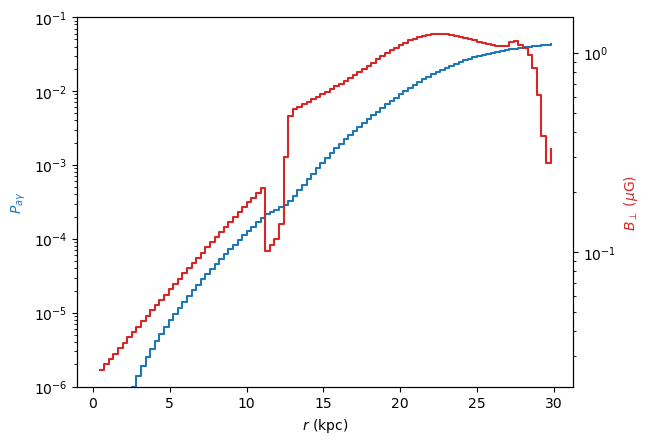

In [10]:
idx = 40
print ("Energy:", EGeV[idx], "GeV")

ax = plt.subplot(111)
ax.semilogy(ml.modules["GMF"].r, (prx[:,idx] + pry[:,idx])[::-1],
            drawstyle='steps')

plt.ylabel("$P_{a\gamma}$", color = plt.cm.tab10(0.))
plt.xlabel("$r$ (kpc)")
ax.set_ylim(1e-6,1e-1)

ax2 = ax.twinx()
ax2.semilogy(ml.modules["GMF"].r, ml.modules["GMF"].B[::-1],
             color = plt.cm.tab10(0.3),
             drawstyle ='steps')
plt.ylabel("$B_{\perp}$ ($\mu$G)", color = plt.cm.tab10(0.3))

Plot the total conversion probability as a function of energy:

Text(0, 0.5, '$P_{a\\gamma}$')

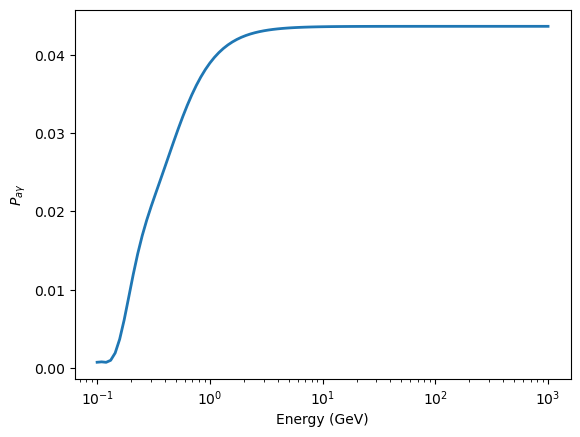

In [11]:
plt.semilogx(EGeV, px[0] + py[0], lw = 2)
plt.xlabel("Energy (GeV)")
plt.ylabel("$P_{a\gamma}$")

## Sky map for mixing in the GMF

Next, we compute a full sky map using `healpy`. In each sky pixel, we calculate the photon-ALP conversion probability at one single energy (1 GeV).

First, we import healpy.

In [16]:
import healpy as hp

ModuleNotFoundError: No module named 'healpy'

In [15]:
import time

And define the pixel grid:

In [ ]:
NSIDE = 30
pix = np.arange(hp.nside2npix(NSIDE))  # get the pixels
ll, bb = hp.pixelfunc.pix2ang(NSIDE, pix, lonlat=True)  #  get the galactic coordinates for each pixel
print (ll.shape)

(10800,)


We loop over the coordinates and for each coordinate we re-initialize the `ModuleList` class
and re-calculate the mixing probability.

In [ ]:
EGeV = np.array([1.])  # energy
pgg = np.zeros((pix.shape[0],EGeV.shape[0]))  # array to store the results
src = Source(z=0.1, ra=0., dec=0.)  # some random source for initialization

# coupling and mass at which we want to calculate the conversion probability:
g = 0.3
m = 1.

t1 = time.time()
for i, l in enumerate(ll):
    src.l = l
    src.b = bb[i]
    ml = ModuleList(ALP(m=m,g=g),
                   src,
                   pin=pa_in,  # pure ALP beam
                   EGeV=EGeV,
                   log_level='warning'  # suppress info calls
                   )
    ml.add_propagation("GMF", 0, model='jansson12')  # add the propagation module
    px, py, pa = ml.run()  # run the code
    pgg[i] = px + py  # save the result

    if i < ll.size - 1:
        del ml

t2 = time.time()
print ("It took", t2-t1, "seconds")

/Users/mey/Python/gammaALPs/gammaALPs/base/transfer.py:799: UserWarning: Not all values of linear polarization are real values!
  warnings.warn("Not all values of linear polarization are real values!")
/Users/mey/Python/gammaALPs/gammaALPs/base/transfer.py:802: UserWarning: Not all values of circular polarization are real values!
  warnings.warn("Not all values of circular polarization are real values!")
/Users/mey/Python/gammaALPs/gammaALPs/base/environs.py:1255: RuntimeWarning: divide by zero encountered in scalar divide
  self._smax = np.amin([self.__zmax/np.abs(sb),


It took 25.066362857818604 seconds


Plot the full sky map using `healpy`'s Mollweide projection:

Text(0.03, 0.93, '$g_{a\\gamma} = 0.30\\times10^{-11}\\,\\mathrm{GeV}^{-1}$')

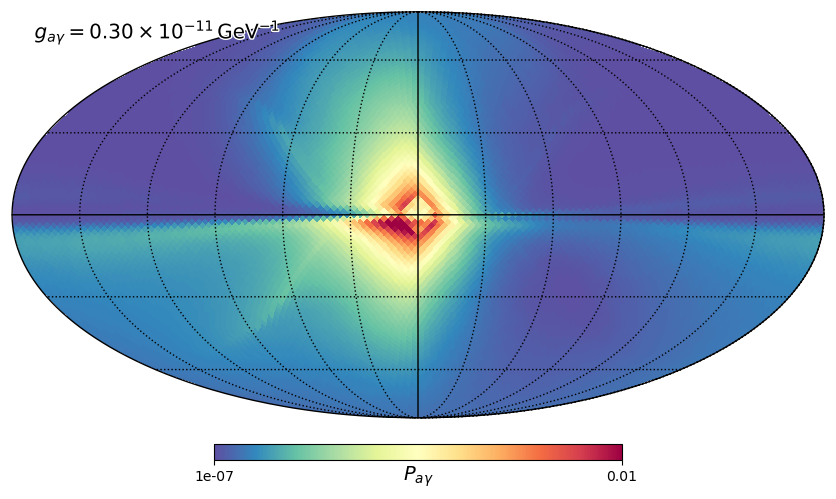

In [ ]:
hpmap = hp.mollview(pgg[:,0],
                    norm='linear',
                    title = '',
                    unit= '$P_{a\gamma}$',
                    min=1e-7,
                    max=1e-2,
                    cmap = 'Spectral_r')
hp.graticule()
plt.annotate("$g_{{a\gamma}} = {0:.2f}\\times10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$".format(ml.alp.g),
            xy = (0.03,0.93), xycoords = 'axes fraction', fontsize = 'x-large', **effect)

We can also use `healpy` to calculate the power spectrum of $P_{a\gamma}$ in terms of an expansion into spherical components and multipole number $\ell$:

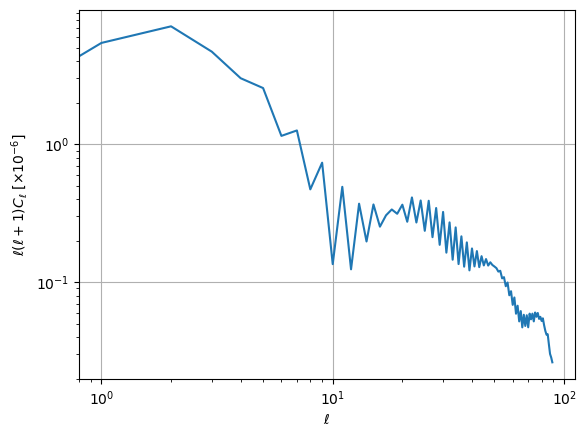

In [ ]:
cl = hp.sphtfunc.anafast(pgg[:,0], gal_cut = 0.)
ell = np.arange(len(cl))

plt.loglog(ell, ell * (ell + 1) * cl * 1e6)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$ [$\\times10^{-6}$]")
plt.grid()